In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Cosine'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

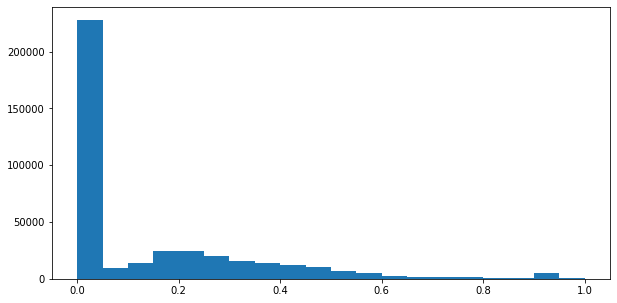

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

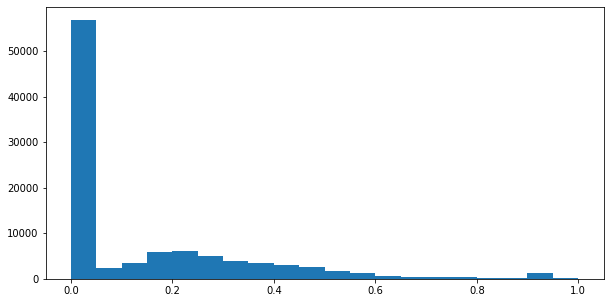

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 8

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

512

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          7230976     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 30s 31ms/step - loss: 0.0038 - ham_dist_loss: 0.0037 - prod_vec_loss: 0.0107 - prod_vec_1_loss: 0.0104 - sum_vec_loss: 1.6382e-04 - sum_vec_1_loss: 1.6531e-04 - ham_dist_rmse: 0.0611 - ham_dist_mae: 0.0236 - val_loss: 7.8949e-04 - val_ham_dist_loss: 7.6378e-04 - val_prod_vec_loss: 0.0023 - val_prod_vec_1_loss: 0.0022 - val_sum_vec_loss: 1.2428e-04 - val_sum_vec_1_loss: 1.1435e-04 - val_ham_dist_rmse: 0.0276 - val_ham_dist_mae: 0.0134
Epoch 2/20
781/781 [==============================] - 22s 28ms/step - loss: 6.0704e-04 - ham_dist_loss: 5.9189e-04 - prod_vec_loss: 0.0016 - prod_vec_1_loss: 0.0016 - sum_vec_loss: 1.0468e-04 - sum_vec_1_loss: 9.9883e-05 - ham_dist_rmse: 0.0243 - ham_dist_mae: 0.0119 - val_loss: 5.3017e-04 - val_ham_dist_loss: 5.2436e-04 - val_prod_vec_loss: 0.0011 - val_prod_vec_1_loss: 0.0011 - val_sum_vec_loss: 1.0610e-04 - val_sum_vec_1_loss: 1.0041e-04 - val_ham_dist_rmse: 0.0229 - val_ham_dist_mae: 0.0111
Epoch 3/

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

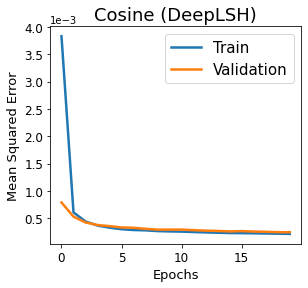

In [22]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('Cosine (DeepLSH)', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

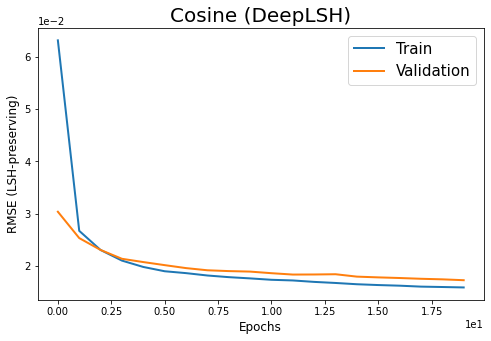

In [24]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Cosine (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

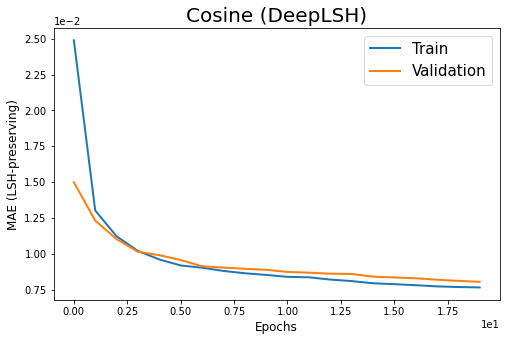

In [25]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Cosine (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [26]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [27]:
np.around(predictions[0][:50],3) 

array([0.   , 0.   , 0.359, 0.311, 0.359, 0.015, 0.25 , 0.   , 0.187,
       0.   , 0.   , 0.   , 0.   , 0.297, 0.   , 0.   , 0.5  , 0.   ,
       0.   , 0.234, 0.   , 0.266, 0.   , 0.   , 0.172, 0.   , 0.   ,
       0.   , 0.505, 0.424, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.391, 0.   , 0.23 , 0.   , 0.   , 0.016, 0.   , 0.327, 0.   ,
       0.313, 0.   , 0.593, 0.094, 0.016], dtype=float32)

In [28]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.373, 0.309, 0.356, 0.   , 0.251, 0.   , 0.198,
       0.   , 0.   , 0.   , 0.   , 0.311, 0.   , 0.   , 0.515, 0.   ,
       0.   , 0.228, 0.   , 0.272, 0.   , 0.   , 0.167, 0.   , 0.   ,
       0.   , 0.5  , 0.429, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.393, 0.   , 0.226, 0.   , 0.   , 0.   , 0.   , 0.333, 0.   ,
       0.361, 0.   , 0.588, 0.081, 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

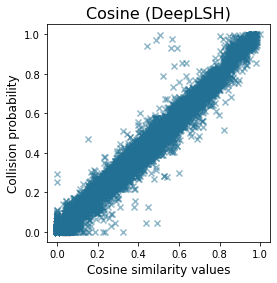

In [29]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Cosine (DeepLSH)', fontsize = 16)
plt.xlabel("Cosine similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/Cosine-correlation', bbox_inches='tight')
plt.show()

In [30]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.929047306934961

In [31]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.8656477866396477

## 3.3. Approximate Hamming Evaluation

In [32]:
output_layer = 2
model.layers[output_layer]

In [33]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [34]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [35]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [36]:
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:32]

array([ 1.        , -1.        ,  1.        , -1.        ,  1.        ,
        0.9999985 , -1.        ,  1.        ,  1.        ,  1.        ,
        1.        , -1.        ,  0.9999988 , -0.99999905, -1.        ,
       -0.99997556, -1.        ,  1.        ,  1.        , -1.        ,
       -1.        , -1.        ,  1.        ,  1.        ,  1.        ,
        1.        , -1.        ,  1.        , -1.        ,  1.        ,
        1.        ,  1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [37]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [38]:
np.mean(np.abs(hash_vectors))

0.9971215

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [39]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.845869140625

### 3.3.4. Comparison between approximate hamming and real hamming

In [40]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

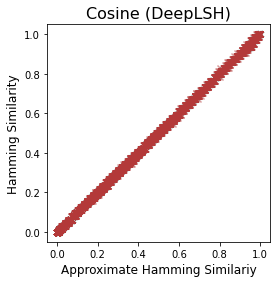

In [41]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Cosine (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Cosine-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [42]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [43]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


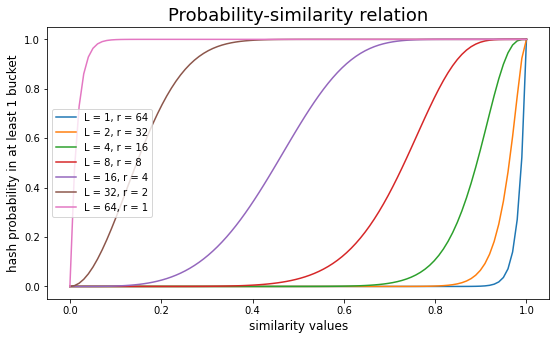

In [44]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [45]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Cosine', trace = False)

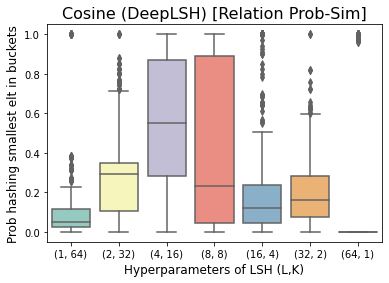

In [46]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Cosine (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/Cosine-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [45]:
'Exemple, L = K = 8'
L, K = params[2]
L, K

(4, 16)

In [46]:
df_probLSH.mean()['(4, 16)']

0.5554183556670129

In [47]:
df_probLSH.median()['(4, 16)']

0.574736566843836

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [48]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [49]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [50]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

718

In [51]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{718, 758}

In [52]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [53]:
near_duplicates_sim = df_measures['Cosine'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

459918    0.984251
Name: Cosine, dtype: float64

In [54]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Cosine', n_stacks, n_duplicate_pairs)
set_real_nns

{758}

In [55]:
real_nns_sim[:n_duplicate_pairs]

459918    0.984251
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [56]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.838

In [57]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9542936288088643

-----------------------------------------------------------------

In [58]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.8906666666666663

In [59]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9517819706498957

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9051999999999992

In [61]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9455621301775153

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [62]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

1.0

In [63]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.948694
(2, 32)    0.940183
(4, 16)    0.946532
(8, 8)     0.871606
(16, 4)    0.877622
(32, 2)    0.979782
(64, 1)    0.999067
dtype: float64

In [64]:
df_knns.mean(skipna = True, axis = 0)['(4, 16)']

0.9465315077963484